In [63]:
%matplotlib inline

In [211]:
from paths import DATA_PATH
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error,mean_absolute_percentage_error
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

from utils import stock_possible_profit_score, stock_option_accuracy_score

In [146]:
df = pd.read_csv(DATA_PATH / 'news_stocks.csv', parse_dates=True)
df = df.reindex(index=df.index[::-1]).reset_index(drop=True)
df

,date,title,text,link,author,label,open,high,low,close,volume
0,2022-05-08,Заявки на транзит российского газа через Украи...,На уровне более 90 миллионов кубометров заявки...,https://www.finam.ru/publications/item/zayavki...,РИА Новости,positive,124.30,126.41,120.90,121.11,580965.0
1,2022-05-08,Юань - хороший инструмент для хеджирования рис...,Ввиду сильной экономики Китая юань менее подве...,https://www.finam.ru/publications/item/yuan-xo...,"Жильников Егор, ""Промсвязьбанк""",positive,124.30,126.41,120.90,121.11,580965.0
2,2022-05-08,"""Сбербанк"" увеличил сумму кредита по ипотеке с...",Сумма кредита по ипотеке с господдержкой увели...,https://www.finam.ru/publications/item/sberban...,Finam.ru,positive,124.30,126.41,120.90,121.11,580965.0
3,2022-05-08,Постпреды ЕС в воскресенье не достигли соглаше...,Венгрия продолжает блокировать предложение Евр...,https://www.finam.ru/publications/item/postpre...,РИА Новости,negative,124.30,126.41,120.90,121.11,580965.0
4,2022-05-08,Реальные доходы россиян в 2022 году могут упас...,По отношению к пиковому 2013 году реальные рас...,https://www.finam.ru/publications/item/realnye...,"Суворов Евгений, банк ""ЦентроКредит""",negative,124.30,126.41,120.90,121.11,580965.0
...,...,...,...,...,...,...,...,...,...,...,...
30609,2023-05-06,Результаты Ford по итогам прошедшего года можн...,Компания явно демонстрирует постепенное урегул...,https://www.finam.ru/publications/item/rezulta...,"Поздняков Дмитрий, Freedom Finance Global",positive,235.83,240.93,233.42,237.06,11352.0
30610,2023-05-06,"Банки США - депозиты сокращаются, кредиты растут",Ребалансировка балансов банков продолжается,https://www.finam.ru/publications/item/banki-s...,Сусин Егор,negative,235.83,240.93,233.42,237.06,11352.0
30611,2023-05-06,"Закрытие дивидендного реестра по ""Сбербанку"" с...",Последний день с рекордными дивидендами акции ...,https://www.finam.ru/publications/item/zakryti...,"Кожухова Елена, ИК ""Велес Капитал""",positive,235.83,240.93,233.42,237.06,11352.0
30612,2023-05-06,Встреча по зерновой сделке на уровне заместите...,"Встреча пройдет с участием России, Украины, Ту...",https://www.finam.ru/publications/item/vstrech...,Finam.ru,positive,235.83,240.93,233.42,237.06,11352.0


In [147]:
target_df = pd.concat([df.open, 
                       df.high, df.low, df.volume, 
                       df.close], axis=1)
target_df

,open,high,low,volume,close
0,124.30,126.41,120.90,580965.0,121.11
1,124.30,126.41,120.90,580965.0,121.11
2,124.30,126.41,120.90,580965.0,121.11
3,124.30,126.41,120.90,580965.0,121.11
4,124.30,126.41,120.90,580965.0,121.11
...,...,...,...,...,...
30609,235.83,240.93,233.42,11352.0,237.06
30610,235.83,240.93,233.42,11352.0,237.06
30611,235.83,240.93,233.42,11352.0,237.06
30612,235.83,240.93,233.42,11352.0,237.06


In [152]:
test_size = 0.22
n_samples = target_df.shape[0]

x = target_df.iloc[:, :-1]
y = target_df.iloc[:, -1]

df_train = target_df[:n_samples - int(n_samples * test_size)]
df_test = target_df[-int(n_samples * test_size):]

x_train = df_train.iloc[:, :-1]
y_train = df_train.iloc[:, -1]
x_test = df_test.iloc[:, :-1]
y_test = df_test.iloc[:, -1]

In [166]:
class StockDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.Tensor(X.to_numpy())
        self.y = torch.Tensor(y.to_numpy()[:,np.newaxis])

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        return self.X[idx], self.y[idx]
    
    
batch_size = 100000000


train_dataset = StockDataset(x_train, y_train)
test_dataset = StockDataset(x_test, y_test)
train_loader = DataLoader(train_dataset, shuffle = False, batch_size=batch_size)
test_loader = DataLoader(test_dataset, shuffle = False, batch_size=batch_size)

In [167]:
import torch
import torch.nn.functional as F
from sklearn.cluster import KMeans

class SOFNN(torch.nn.Module):
    def __init__(self, n_clusters=4):
        super(SOFNN, self).__init__()
        self.fuzzy_layer = torch.nn.Linear(n_clusters, 100)
        self.output_layer = torch.nn.Linear(100, 1)
        self.kmeans = KMeans(n_clusters=n_clusters, n_init=10)

    def forward(self, x):
        x_clustered = self.kmeans.fit_transform(x)

        fuzzy_output = self.fuzzy_layer(torch.Tensor(x_clustered))

        output = self.output_layer(fuzzy_output)
        return output

def train(model, x_train, y_train):
#     optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
#         criterion = torch.nn.BCELoss()
    criterion = torch.nn.MSELoss()

    for epoch in range(100):
        optimizer.zero_grad()
        output = model(x_train)
        loss = criterion(output, y_train.float())
        loss.backward()
        optimizer.step()

        if epoch % 1 == 0:
            print("Epoch: %d, Loss: %.3f" % (epoch, loss.item()))
            
            
            
def train_model(data_loader, model, loss_function, optimizer):
    num_batches = len(data_loader)
    total_loss = 0
    model.train()
    
    for X, y in data_loader:
        output = model(X)
        optimizer.zero_grad()

        loss = loss_function(output, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / num_batches
    print(f"Train loss: {avg_loss}")
    return avg_loss

def test_model(data_loader, model, loss_function):
    
    num_batches = len(data_loader)
    total_loss = 0

    model.eval()
    with torch.no_grad():
        for X, y in data_loader:
            output = model(X)
            total_loss += loss_function(output, y).item()

    avg_loss = total_loss / num_batches
    print(f"Test loss: {avg_loss}")
    return avg_loss

Untrained test
--------
Test loss: 15226515456.0

Epoch 0
---------
Train loss: 45150248960.0
Test loss: 75729744166912.0

Epoch 1
---------
Train loss: 7898963902464.0
Test loss: 607486935040.0

Epoch 2
---------
Train loss: 34779602944.0
Test loss: 5365077901312.0

Epoch 3
---------
Train loss: 680102264832.0
Test loss: 8633975308288.0

Epoch 4
---------
Train loss: 480694370304.0
Test loss: 7897654231040.0

Epoch 5
---------
Train loss: 1312549502976.0
Test loss: 621547159552.0

Epoch 6
---------
Train loss: 235204608000.0
Test loss: 9468759769088.0

Epoch 7
---------
Train loss: 1036783386624.0
Test loss: 2749265346560.0

Epoch 8
---------
Train loss: 1345477804032.0
Test loss: 6275016949760.0

Epoch 9
---------
Train loss: 993099776000.0
Test loss: 6126214053888.0

Epoch 10
---------
Train loss: 1878804267008.0
Test loss: 772792778752.0

Epoch 11
---------
Train loss: 445853990912.0
Test loss: 10389237530624.0

Epoch 12
---------
Train loss: 820446101504.0
Test loss: 5519520353484

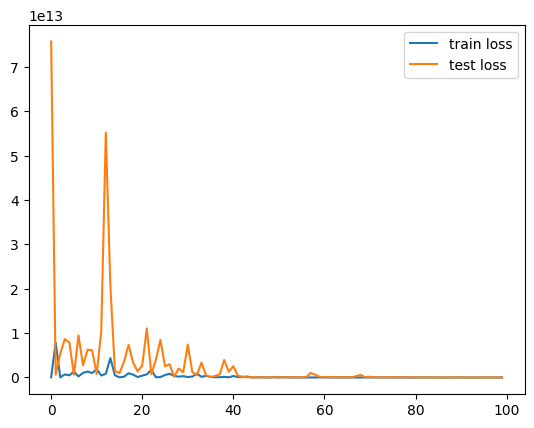

In [168]:
epochs_count = 100
model = SOFNN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
loss_function = torch.nn.MSELoss()


print("Untrained test\n--------")
test_model(test_loader, model, loss_function)
print()

train_losses = []
test_losses = []


for ix_epoch in range(epochs_count):
    print(f"Epoch {ix_epoch}\n---------")
    train_loss = train_model(train_loader, model, loss_function, optimizer=optimizer)
    train_losses.append(train_loss)
    test_loss = test_model(test_loader, model, loss_function)
    test_losses.append(test_loss)

    print()

fig, ax = plt.subplots(1,1)
    
ax.plot(train_losses, label='train loss')
ax.plot(test_losses, label='test loss')
ax.legend()


In [169]:
def running_mean(x, N,mode='valid'):
    return np.convolve(x, np.ones((N,))/N, mode=mode)

def model_results(moving_average=None):
    y_test = df_test['close']
    y_test_pred = model(x_test).detach().squeeze(1).numpy()

    print('Test MSE', mean_squared_error(y_test, y_test_pred))
    print('Test MAPE', mean_absolute_percentage_error(y_test, y_test_pred))
    y_pred = model(x).detach().squeeze(1).numpy()
    y = target_df['close']
    if moving_average:
        y_pred = running_mean(y_pred, moving_average)
        
        y_test_pred_smooth = running_mean(y_test_pred, moving_average, mode='same')
        print('Smoothed Test MSE', mean_squared_error(y_test, y_test_pred_smooth))
        print('Smoothed Test MAPE', mean_absolute_percentage_error(y_test, y_test_pred_smooth))
    fig, ax = plt.subplots(1,1)
    train_size = len(df_train)
    y_pred = pd.Series(y_pred)
    ax.plot(y, label='true')
    ax.plot(y_pred, label='pred')
#     ax.set_ylim((y.min()-10, y.max()+10))
    plt.axvline(x=train_size, c='r', linestyle='--')
    ax.legend()

Test MSE 37396641644.049774
Test MAPE 975.7868468259609


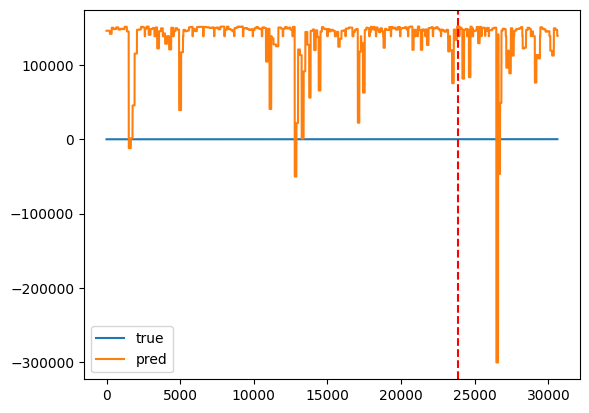

In [170]:
model_results(moving_average=None)

In [184]:
y_pred = model(x_test).detach().squeeze(1).numpy()
y_pred = pd.Series(y_pred, index=df_test['close'].index)

In [208]:
stock_possible_profit_score(df, df_test['close'], y_pred)

1.2118065179071769

In [209]:
stock_option_accuracy_score(df, df_test['close'], y_pred)

0.5294117647058824

In [210]:
del stock_possible_profit_score

In [213]:
import inspect
print(inspect.getsource(stock_possible_profit_score))

def stock_possible_profit_score(df, y_true, y_pred):
    true_pred_by_date = pd.concat([df.iloc[y_true.index].date, y_true, y_pred], axis=1).groupby('date').mean()
    true_pred_by_date_prev = true_pred_by_date.iloc[:-1]
    true_pred_by_date_curr = true_pred_by_date.iloc[1:]
    true_pred_diff = true_pred_by_date_curr.to_numpy() - true_pred_by_date_prev.to_numpy()
    true_pred_binary = true_pred_diff > 0
    true_binary = true_pred_binary[:,0]
    pred_binary = true_pred_binary[:,1]
    profit_precent = np.abs(1 - (true_pred_by_date_curr.to_numpy() / true_pred_by_date_prev.to_numpy())[:,0])
    precent_changes = profit_precent * np.where((true_binary==pred_binary), 1, -1)

    return 100 * (np.prod(1 + precent_changes) - 1)

